[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/master/scripts/interactive/example_one_bundesland.ipynb)

In [ ]:
!pip install covid19_inference



# Example for one region (bundesland)
Non-hierarchical model using rki data.

Runtime ~ 15 min

The first thing we need to do is import some essential stuff. Theses have to be installed and are prerequisites.


In [1]:
import datetime
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import aesara.tensor as at
import pymc as pm

In [3]:
# Now to the fun stuff, we import our module!
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19


## Data retrieval

The next thing we want to do is (down)load a dataset. We have retrievers for multiple download sources.
Documentation can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html).
In this example we will use the RKI dataset.


In [4]:
rki = (
    cov19.data_retrieval.RKI()
)  # One could also parse True to the constructor of the class to force an auto download
rki.download_all_available_data()

INFO     [covid19_inference.data_retrieval.retrieval] Successfully downloaded Rki.csv.gz to /tmp/covid19_data/.
INFO     [covid19_inference.data_retrieval.retrieval] Local backup to /tmp/covid19_data/Rki.csv.gz successful.




We can now access this downloaded data by the attribute
```
rki.data
```
but normally one would use the build in filter methods,
these can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html#covid19_inference.data_retrieval.JHU.get_new).

Next we retrieve the filtered data from our source in this example we will get all new cases and the total (cumulative) cases for the bundesland "Sachsen".


In [5]:
bd = datetime.datetime(2020, 3, 10)  # For the date filter
ed = datetime.datetime(2020, 6, 10)

In [6]:
total_cases_obs = rki.get_total(
    value="confirmed", bundesland="Sachsen", data_begin=bd, data_end=ed
)
new_cases_obs = rki.get_new(
    value="confirmed", bundesland="Sachsen", data_begin=bd, data_end=ed
)



## Create the model

First we need to set the priors for the change points and other configs.


In [7]:
diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 10

In [8]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 9)
prior_date_strong_dist_begin = datetime.datetime(2020, 3, 16)
prior_date_contact_ban_begin = datetime.datetime(2020, 3, 23)

In [9]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]



Next, we create the model! There are default values for most of the function arguments,
but we will try to explicitly set all kwargs for the sake of this example.


In [10]:
params_model = dict(
    new_cases_obs=new_cases_obs[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=4e6,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 10



The model is specified in a context. Each function in this context
has access to the model parameters set.


In [11]:
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.LogNormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    I_begin = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        I_begin=I_begin,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        delay_kernel="lognormal",
        median_delay_kwargs={
            "name": "delay",
            "mu": np.log(pr_delay),
            "sigma": 0.2,
        },
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        week_modulation_type="step",
        weekend_factor_kwargs={
            "name": "weekend_factor",
            "mu": np.log(0.3),
            "sigma": 0.5,
        },
        weekend_days=(6, 7),
    )
    pm.Deterministic("new_cases", new_cases)

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate.lambda_t_with_sigmoids] Lambda_t with sigmoids
INFO     [covid19_inference.model.utility] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.utility] pr_sigma_transient_len was set to default value 1
INFO     [covid19_inference.model.utility] relative_to_previous was set to default value False
INFO     [covid19_inference.model.utility] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.utility] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.utility] pr_sigma_transient_len was set to default value 1
INFO     [covid19_inference.model.utility] relative_to_previous was set to default value False
INFO     [covid19_inference.model.utility] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.utility] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.utility] pr_sigma_transient_


## MCMC sampling

After the model is built, it is sampled using a MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
The sampling can take a long time.


In [12]:
idata = pm.sample(model=this_model, tune=1000, draws=1000, init="advi+adapt_diag")

Auto-assigning NUTS sampler...
INFO     [pymc] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc] Initializing NUTS using advi+adapt_diag...


Convergence achieved at 9300
INFO     [pymc.variational.inference] Convergence achieved at 9300
Interrupted at 9,299 [4%]: Average Loss = 546.45
INFO     [pymc.variational.inference] Interrupted at 9,299 [4%]: Average Loss = 546.45
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, transient_day_1, transient_day_2, transient_day_3, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, mu, I_begin_ratio_log, delay_log, weekend_factor_log, sigma_obs]
INFO     [pymc] NUTS: [lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, transient_day_1, transient_day_2, transient_day_3, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_, mu, I_begin_ratio_log, delay_log, weekend_factor_log, sigma_obs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1395 seconds.
INFO     [pymc] Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1395 seconds.



## Plotting
Plotting tools are rudimentary right now. But one can always write custom plotting function
by accessing the samples stored in the inference data. See the arviz [documentation](https://arviz-devs.github.io/arviz/getting_started/XarrayforArviZ.html#xarray-for-arviz) for a indepth explanation of the inference data structure.

### Distributions


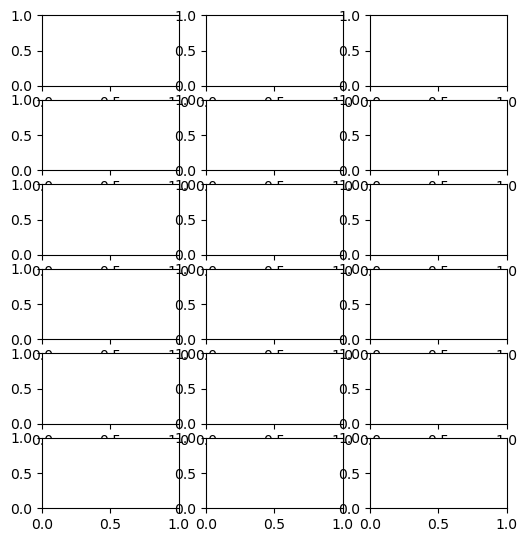

In [13]:
fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))

In [14]:
# Get the free Random Variables
varnames = this_model.untransformed_freeRVs
print(varnames)

['lambda_0_log_', 'lambda_1_log_', 'lambda_2_log_', 'lambda_3_log_', 'transient_day_1', 'transient_day_2', 'transient_day_3', 'transient_len_1_raw_', 'transient_len_2_raw_', 'transient_len_3_raw_', 'mu', 'I_begin_ratio_log', 'delay_log', 'weekend_factor_log', 'sigma_obs']


In [15]:
# Plot them
for i, (key, math) in enumerate(
    # left column
    zip(
        ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"],
        ["\Phi_w", "\mu", "\lambda_0", "\lambda_1", "\lambda_2", "\lambda_3"],
    )
):
    cov19.plot.distribution(this_model, idata, key, ax=axes[i, 0], dist_math=math)

Sampling: [weekend_factor_log]
INFO     [pymc] Sampling: [weekend_factor_log]
Sampling: [mu]
INFO     [pymc] Sampling: [mu]
Sampling: [lambda_0_log_]
INFO     [pymc] Sampling: [lambda_0_log_]
Sampling: [lambda_1_log_]
INFO     [pymc] Sampling: [lambda_1_log_]
Sampling: [lambda_2_log_]
INFO     [pymc] Sampling: [lambda_2_log_]
Sampling: [lambda_3_log_]
INFO     [pymc] Sampling: [lambda_3_log_]


In [17]:
for i, (key, math) in enumerate(
    # mid column
    zip(
        [
            "sigma_obs",
            "I_begin",
            "transient_day_1",
            "transient_day_2",
            "transient_day_3",
        ],
        [
            "\sigma_{obs}",
            "I_0",
            "t_1",
            "t_2",
            "t_3",
        ],
    )
):
    cov19.plot.distribution(
        this_model,
        idata,
        key,
        ax=axes[i, 1],
        dist_math=math,
    )

Sampling: [sigma_obs]
INFO     [pymc] Sampling: [sigma_obs]
Sampling: [I_begin_ratio_log, lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, mu, transient_day_1, transient_day_2, transient_day_3, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_]
INFO     [pymc] Sampling: [I_begin_ratio_log, lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, mu, transient_day_1, transient_day_2, transient_day_3, transient_len_1_raw_, transient_len_2_raw_, transient_len_3_raw_]
Sampling: [transient_day_1]
INFO     [pymc] Sampling: [transient_day_1]
Sampling: [transient_day_2]
INFO     [pymc] Sampling: [transient_day_2]
Sampling: [transient_day_3]
INFO     [pymc] Sampling: [transient_day_3]


In [18]:
for i, (key, math) in enumerate(
    # right column
    zip(
        [
            "delay",
            "transient_len_1",
            "transient_len_2",
            "transient_len_3",
        ],
        ["D", "\Delta t_1", "\Delta t_2", "\Delta t_3"],
    )
):
    cov19.plot.distribution(
        this_model,
        idata,
        key,
        ax=axes[i + 2, 2],
        dist_math=math,
    )

Sampling: [delay_log]
INFO     [pymc] Sampling: [delay_log]
Sampling: [transient_len_1_raw_]
INFO     [pymc] Sampling: [transient_len_1_raw_]
Sampling: [transient_len_2_raw_]
INFO     [pymc] Sampling: [transient_len_2_raw_]
Sampling: [transient_len_3_raw_]
INFO     [pymc] Sampling: [transient_len_3_raw_]


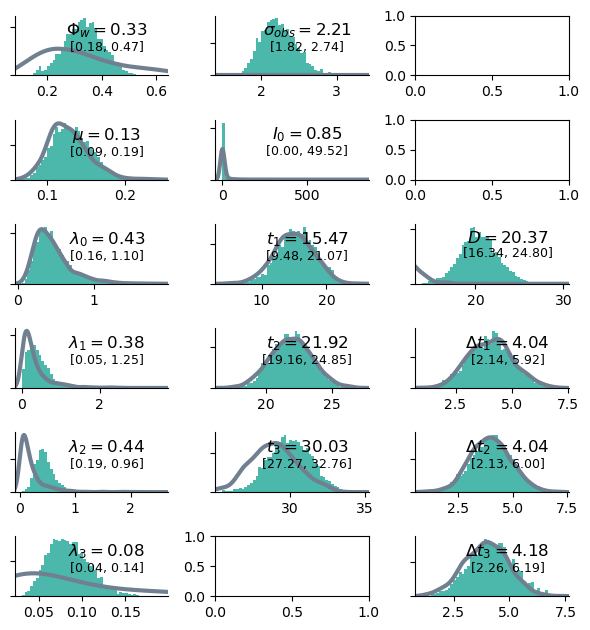

In [19]:
fig.tight_layout()
fig  # To print in jupyter notebook


### Timeseries
timeseries overview, for now needs an offset variable to get cumulative cases


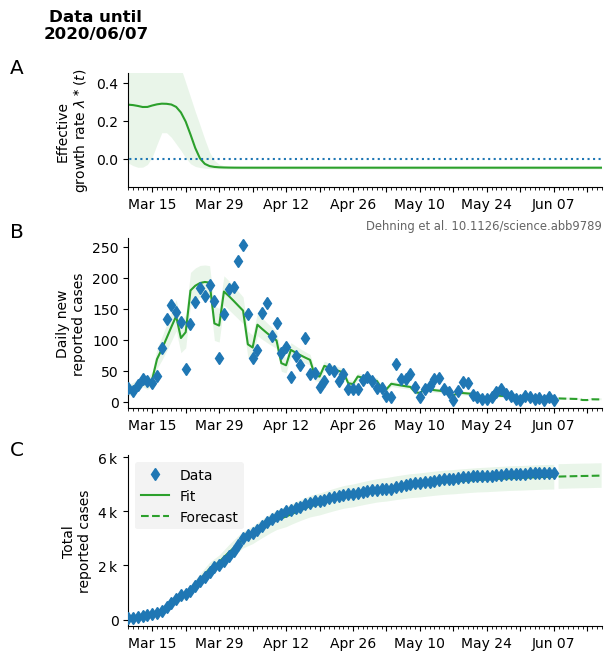

In [20]:
fig, axes = cov19.plot.timeseries_overview(this_model, idata, offset=total_cases_obs[0])

In [26]:
%load_ext watermark
%watermark  -iv

matplotlib       : 3.6.2
aesara           : 2.8.7
pymc             : 4.4.0
sys              : 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]
numpy            : 1.23.5
covid19_inference: 0.4.0

